# 報酬の分布が非定常の時のバンディット問題

今日は報酬の分布が非定常な時のバンディットのコードを実装していきます．

報酬の分布が定常というのはスロットマシーンなどがあげられます．

今回の非定常の報酬の実装は**平均0,標準偏差1**の正規分布から生成される乱数をノイズとして採用します．
 
 ---

価値を推定するために標本平均を採用すると次の式になります．

$Q_{n}$ は $n$ 回目の価値(標本平均), $R_{n}$ は アーム$i$を引いた時の価値とします．

$$
Q_{n} = \frac{R_{1} + R_{2} + ... + R_{n}}{n}
$$

となります．

しかしながら, プログラムで書く際にはいちいちこの計算をするのは賢くないので, 次の式を使います．

$$
Q_{n} = Q_{n-1} + \frac{1}{n} (R_{n} - Q_{n-1})
$$

となります．

式変形をしているだけなので, 1番最初の式を結果は同じになります．


1番最初の式を見ると, 1番新しく得られた報酬と1番古い報酬の重要度を同じ重さで計算していることになります．

環境などが変わってしまう場合は, 最新の情報や報酬を重要度が高いですよね．

なので, $\frac{1}{n}$ の代わりに新しい重み $\alpha$ を採用します．

$$
Q_{n} = Q_{n-1} + \alpha (R_{n} - Q_{n-1})
$$

この式をわかりやすく変形すると

$$
Q_{n} = \alpha R_{n} + (1 - \alpha)Q_{n-1}
$$

となります，
$n = n-1$ の時は

$$
Q_{n-1} = \alpha R_{n-1} + (1 - \alpha)Q_{n-2}
$$

1番上の式の $Q_{n-1}$ を代入する操作を $n=0$ まで繰り返して再帰的に式を書き換えると,

$$
Q_{n} = \alpha R_{n} + \alpha (1 - \alpha) R_{n-1} + \alpha (1 - \alpha) ^ 2 R_{n-2} + ... + (1 - \alpha) ^ n Q_{0}
$$





このようにすると古い履歴の報酬から適切な $\alpha$ (ex. $\alpha = 0.9$) を設定すれば, うまく減衰することができますね．

---

早速コードを書いていきましょう．

In [51]:
import jax.numpy as jnp
import numpy as np
import jax


#非定常な環境
class Bandit_Env:
    def __init__(self, arms:int =5):
        self.arms = arms
        self.rewards = np.random.rand(arms)

    #報酬を返す関数
    def get_reward(self,arm: int):
        reward = self.rewards[arm]
        self.rewards += 0.1 * np.random.rand(self.arms)

        if reward > np.random.rand():
            return 1

        else:
            return 0

In [52]:
epsilon = 0.3
arms = 5

In [53]:

@jax.jit
def update(arm:int ,reward:float, alpha:float,Q_arm:np.ndarray):
    
    Q_arm = Q_arm.at[arm].add(alpha * (reward - Q_arm[arm]))

def choose_arm(epsilon,Q_arm):
    if np.random.rand() < epsilon:
        return np.random.choice(a =arms,size=1)
    else:
        return np.argmax(Q_arm)
    


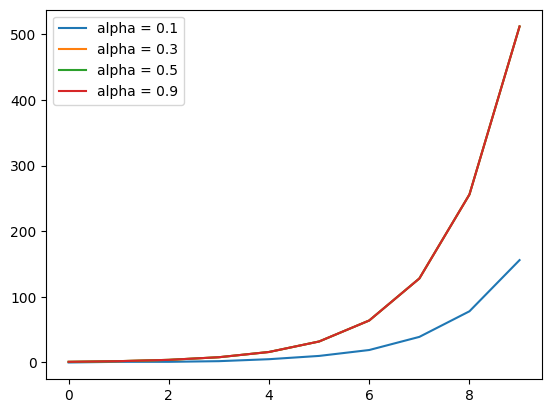

In [69]:
import matplotlib.pyplot as plt
iteration = 10
alphas = [0.1,0.3,0.5,0.9]

env = Bandit_Env(arms=arms)

for alpha_index in range(len(alphas)):
    cul_rewards = []
    Q_arm = jnp.zeros(arms)
    for i in range(iteration):
        arm = choose_arm(epsilon,Q_arm)
        r = env.get_reward(arm)
        cul_rewards.append(r + sum(cul_rewards))
        update(arm,r,alphas[alpha_index],Q_arm)
    plt.plot(np.arange(iteration),cul_rewards,label= f'alpha = {alphas[alpha_index]}')

plt.legend()
plt.show()